<a href="https://colab.research.google.com/github/abdulrahman-riyad/real-time-reviews-analysis/blob/Approach2/aspect_sentiment_analysis_classifier_roBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import string
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from google.colab import drive
from transformers import Trainer, TrainingArguments, AutoTokenizer, RobertaModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/restaurants_reviews_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation


## Loading the Data

In [ ]:
df1 = pd.read_csv(data_path + '/Restaurants_Train_v2.csv')
df1.head()

,id,Sentence,Aspect Term,polarity,from,to
0,3121,But the staff was so horrible to us.,staff,negative,8,13
1,2777,"To be completely fair, the only redeeming fact...",food,positive,57,61
2,1634,"The food is uniformly exceptional, with a very...",food,positive,4,8
3,1634,"The food is uniformly exceptional, with a very...",kitchen,positive,55,62
4,1634,"The food is uniformly exceptional, with a very...",menu,neutral,141,145


In [ ]:
df2 = pd.read_csv(data_path + '/Laptop_Train_v2.csv')
df2.head()

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12


In [ ]:
df = pd.concat([df1, df2])

In [ ]:
df.isna().sum()

,0
id,0
Sentence,0
Aspect Term,0
polarity,0
from,0
to,0


In [ ]:
df.shape

(6051, 6)

In [ ]:
class_counts = df["polarity"].value_counts()
class_counts

,count
polarity,
positive,3151
negative,1671
neutral,1093
conflict,136


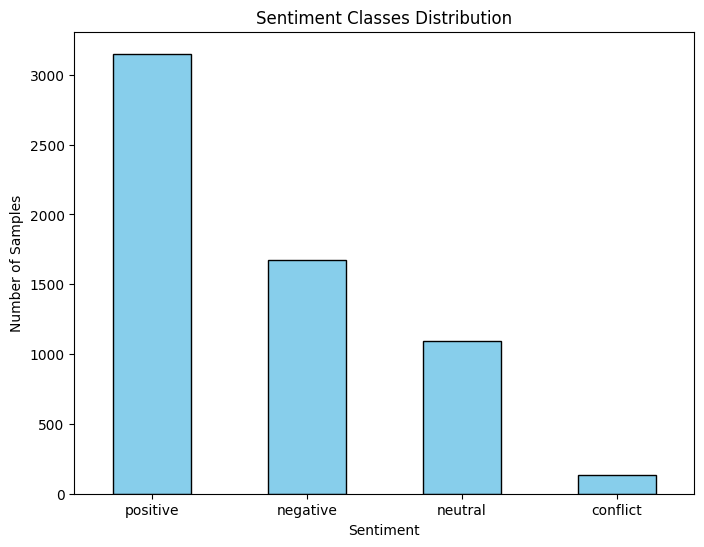

In [ ]:
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel("Sentiment")
plt.ylabel("Number of Samples")
plt.title("Sentiment Classes Distribution")
plt.xticks(rotation=0)

plt.show()

## Dropping Unimportant Columns & Rows

In [ ]:
df.drop(['id', 'from', 'to'], axis=1, inplace=True)

In [ ]:
df.head()

,Sentence,Aspect Term,polarity
0,But the staff was so horrible to us.,staff,negative
1,"To be completely fair, the only redeeming fact...",food,positive
2,"The food is uniformly exceptional, with a very...",food,positive
3,"The food is uniformly exceptional, with a very...",kitchen,positive
4,"The food is uniformly exceptional, with a very...",menu,neutral


In [ ]:
df.drop(df[df.polarity == 'conflict'].index, inplace = True)

In [ ]:
df = df.rename(columns={"Sentence": "text", "Aspect Term": "aspect", "polarity": "label"})

In [ ]:
df.shape

(5818, 3)

## Cleaning Reviews Text

In [ ]:
def clean_text(text):
  """Clean and preprocess text data
  Parameters:
  -----------
  text : str
  The text to clean

  Returns:
  --------
  str
  Cleaned text
  """

  # Convert to lowercase
  text = text.lower()

  # Handle contractions
  contractions = {
      "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not","haven't": "have not",
      "hasn't": "has not", "hadn't": "had not", "doesn't": "does not", "don't": "do not", "didn't": "did not",
      "won't": "will not", "wouldn't": "would not", "can't": "cannot", "couldn't": "could not", "shouldn't": "should not",
      "mightn't": "might not", "mustn't": "must not", "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
      "it's": "it is", "we're": "we are", "they're": "they are", "i've": "i have", "you've": "you have", "we've": "we have",
      "they've": "they have", "i'd": "i would", "you'd": "you would", "he'd": "he would", "she'd": "she would", "it'd": "it would",
      "we'd": "we would", "they'd": "they would", "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will",
      "it'll": "it will", "we'll": "we will", "they'll": "they will", "didnt": "did not", "dont": "do not", "cant": "cannot", "wont": "will not",
      }

  for contraction, expansion in contractions.items():
    text = text.replace(contraction, expansion)

  # Preserve emotions
  emoticons = {
      ':)': ' HAPPY_FACE ',
      ':(': ' SAD_FACE ',
      ':D': ' LAUGH_FACE ',
      ':/': ' CONFUSED_FACE '
      }
  for emoticon, replacement in emoticons.items():
    text = text.replace(emoticon, replacement)


  # Remove punctuation but preserve sentence structure
  text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  # Restore emotions
  for placeholder, emoticon in {v: k for k, v in emoticons.items()}.items():
    text = text.replace(placeholder, emoticon)

  return text

## Encoding Polarity Column

In [ ]:
sentiment_encoder = LabelEncoder()

df['label'] = sentiment_encoder.fit_transform(df['label'])

label_mapping = dict(zip(sentiment_encoder.classes_, range(len(sentiment_encoder.classes_))))
print(label_mapping)

{'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
df['label'].dtype

dtype('int64')

In [ ]:
df["label"] = df["label"].apply(
    lambda x: x.iloc[0] if isinstance(x, pd.Series) else (x[0] if isinstance(x, list) else x)
)


In [ ]:
print(type(df.loc[0, "label"]))   # Should print: <class 'int'>


<class 'pandas.core.series.Series'>


In [ ]:
print(df["label"].iloc[0])
print(type(df["label"].iloc[0]))

0
<class 'numpy.int64'>


# Fine-Tuning roBERTa

In [ ]:
train_df, tst_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(tst_df, test_size=0.3, random_state=42)

### Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Dataset Class


In [ ]:
class AspectSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.df = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      if isinstance(idx, (list, np.ndarray, pd.Series)):
            if len(idx) != 1:
                raise ValueError(f"Expected scalar idx, but got batch: {idx}")
            idx = int(idx[0])
      elif isinstance(idx, torch.Tensor):
            idx = idx.item()
      else:
            idx = int(idx)

      # Safe scalar access
      review = str(self.df.at[idx, "text"])
      aspect = str(self.df.at[idx, "aspect"])
      label = int(self.df.at[idx, "label"])

      encoded = self.tokenizer(
          review,
          aspect,
          truncation=True,
          padding="max_length",
          max_length=self.max_len,
          return_tensors="pt"
      )
      item = {
          "input_ids": encoded["input_ids"].squeeze(0),
          "attention_mask": encoded["attention_mask"][0].squeeze(0),
          "label": torch.tensor(label, dtype=torch.long)
          }
      return item

In [ ]:
train_dataset = AspectSentimentDataset(train_df, tokenizer)
val_dataset = AspectSentimentDataset(val_df, tokenizer)
test_dataset = AspectSentimentDataset(test_df, tokenizer)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

## Saving Functions

In [ ]:
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }
    torch.save(checkpoint, filename)

In [ ]:
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

## Trial 1


### Model Architecture

In [ ]:
class AspectSentimentClassifier(nn.Module):
    def __init__(self, model_name='roberta-base', num_labels=3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)

        hidden_size = self.roberta.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        return logits

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model1 = AspectSentimentClassifier()
model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model1.parameters(), lr=2e-5)

epochs = 5

def compute_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return (preds == labels).float().mean().item()

Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training
best_val_acc = 0.0
best_val_loss = float('inf')

for epoch in range(epochs):
    model1.train()
    total_train_loss = 0
    total_train_acc = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model1(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        acc = compute_accuracy(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += acc

        loop.set_postfix(loss=loss.item(), acc=acc)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    print(f"\nTrain Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")

    # Validation
    model1.eval()
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model1(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_val_loss += loss.item()
            total_val_acc += acc

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}\n")

    # Save model only if val accuracy is better AND val loss doesn't increase significantly
    if avg_val_acc > best_val_acc and avg_val_loss <= best_val_loss + 0.01:
        best_val_acc = avg_val_acc
        best_val_loss = avg_val_loss
        save_checkpoint(model1, optimizer, epoch, avg_val_loss, 'best_model1.pth')
        print(f"✅ New best model saved with acc: {best_val_acc:.4f}, loss: {best_val_loss:.4f}\n")

Epoch 1/5: 100%|██████████| 291/291 [01:43<00:00,  2.80it/s, acc=0.786, loss=0.631]



Train Loss: 0.6746 | Train Acc: 0.7190
Val Loss: 0.5214 | Val Acc: 0.7801

✅ New best model saved with acc: 0.7801, loss: 0.5214



Epoch 2/5: 100%|██████████| 291/291 [01:42<00:00,  2.83it/s, acc=0.929, loss=0.121]



Train Loss: 0.4262 | Train Acc: 0.8359
Val Loss: 0.5837 | Val Acc: 0.8057



Epoch 3/5: 100%|██████████| 291/291 [01:42<00:00,  2.84it/s, acc=0.929, loss=0.293]



Train Loss: 0.3090 | Train Acc: 0.8937
Val Loss: 0.4394 | Val Acc: 0.8283

✅ New best model saved with acc: 0.8283, loss: 0.4394



Epoch 4/5: 100%|██████████| 291/291 [01:42<00:00,  2.84it/s, acc=0.929, loss=0.35]



Train Loss: 0.2157 | Train Acc: 0.9315
Val Loss: 0.4315 | Val Acc: 0.8561

✅ New best model saved with acc: 0.8561, loss: 0.4315



Epoch 5/5: 100%|██████████| 291/291 [01:42<00:00,  2.83it/s, acc=1, loss=0.0975]



Train Loss: 0.1528 | Train Acc: 0.9500
Val Loss: 0.5004 | Val Acc: 0.8479



### Model Evaluation on Test Data

In [ ]:
def test_model(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            # Move to GPU if available
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            model = model.to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)

            # Compute predictions and metrics
            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += input_ids.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [ ]:
model1, optimizer, loaded_epoch, loaded_loss = load_checkpoint(model1, optimizer, 'best_model1.pth')

test_loss, test_acc = test_model(model1, test_loader, criterion)

Test Loss: 0.5373 | Test Accuracy: 0.8486


In [ ]:
save_checkpoint(model1, optimizer, epoch, avg_val_loss, data_path + '/roBERTa_model_v1.pth')

## Trial 2

### Model Architenture
**Reducing the density of the classifir and adding droupout for bettter generalization**

In [ ]:
class AspectSentimentClassifier2(nn.Module):
    def __init__(self, model_name='roberta-base', num_labels=3):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)

        hidden_size = self.roberta.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )


    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        return logits

### Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model2 = AspectSentimentClassifier2()
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=2e-5)

epochs = 5

def compute_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    return (preds == labels).float().mean().item()

Using device: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training
best_val_acc = 0.0
best_val_loss = float('inf')
for epoch in range(epochs):
    model2.train()
    total_train_loss = 0
    total_train_acc = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model2(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        acc = compute_accuracy(outputs, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += acc

        loop.set_postfix(loss=loss.item(), acc=acc)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    print(f"\nTrain Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")

    # Validation
    model2.eval()
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model2(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_val_loss += loss.item()
            total_val_acc += acc

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}\n")

    # Save model only if val accuracy is better AND val loss doesn't increase significantly
    if avg_val_acc > best_val_acc and avg_val_loss <= best_val_loss + 0.01:
        best_val_acc = avg_val_acc
        best_val_loss = avg_val_loss
        save_checkpoint(model2, optimizer, epoch, avg_val_loss, 'best_model2.pth')
        print(f"✅ New best model saved with acc: {best_val_acc:.4f}, loss: {best_val_loss:.4f}\n")


Epoch 1/5: 100%|██████████| 291/291 [01:43<00:00,  2.80it/s, acc=0.571, loss=0.88]



Train Loss: 0.7322 | Train Acc: 0.6955
Val Loss: 0.5156 | Val Acc: 0.7901

✅ New best model saved with acc: 0.7901, loss: 0.5156



Epoch 2/5: 100%|██████████| 291/291 [01:43<00:00,  2.82it/s, acc=0.643, loss=0.974]



Train Loss: 0.4487 | Train Acc: 0.8330
Val Loss: 0.4822 | Val Acc: 0.7990

✅ New best model saved with acc: 0.7990, loss: 0.4822



Epoch 3/5: 100%|██████████| 291/291 [01:44<00:00,  2.78it/s, acc=0.929, loss=0.215]



Train Loss: 0.3261 | Train Acc: 0.8814
Val Loss: 0.4234 | Val Acc: 0.8332

✅ New best model saved with acc: 0.8332, loss: 0.4234



Epoch 4/5: 100%|██████████| 291/291 [01:45<00:00,  2.76it/s, acc=0.857, loss=0.39]



Train Loss: 0.2290 | Train Acc: 0.9237
Val Loss: 0.5331 | Val Acc: 0.8223



Epoch 5/5: 100%|██████████| 291/291 [01:43<00:00,  2.80it/s, acc=0.929, loss=0.26]



Train Loss: 0.1619 | Train Acc: 0.9456
Val Loss: 0.5656 | Val Acc: 0.8454



### Model Evalutaion on Test Data

In [ ]:
model2, optimizer, loaded_epoch, loaded_loss = load_checkpoint(model2, optimizer, 'best_model2.pth')

test_loss, test_acc = test_model(model2, test_loader, criterion)

Test Loss: 0.5103 | Test Accuracy: 0.8171


In [ ]:
save_checkpoint(model2, optimizer, epoch, avg_val_loss, data_path + '/roBERTa_model_v2.pth')